In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,precision_recall_curve, f1_score,make_scorer, fbeta_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
#from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier


/home/omarfetou7/anaconda3/envs/ml-lab1/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
df = pd.read_csv("data/datatrain.csv")
X = df.select_dtypes(include=["number"]).drop(columns=["target","Created At Year","hour","minute","second","Countries_ID","Created At Month"])
# X = df[cols]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [3]:
X

,FeatureX,FeatureY,Created At Day_of_month,job_activity_count,comp_activity_count,blog_activity_count,badge_activity_count,$create_alias,$identify,Accepted Team Leadership Transfer,...,subm count 10,subm count 3,subm count 8,subm count 9,subm count 6,subm count 7,subm count 5,subm count 4,comments_count,discussions_count
0,0,0,16,0,0,0,1,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,27,1,3,0,0,1.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,27,0,1,0,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,16,0,14,1,1,1.0,1.0,0.0,...,1,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9063,0,1,7,0,0,0,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9064,0,1,6,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9065,0,1,25,0,0,0,1,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9066,0,1,7,0,8,0,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=4,
    random_state=42,
    class_weight='balanced'
)


In [5]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, beta=1):
    """
    Trains the model, evaluates default and optimal threshold, and plots results.
    """
    model.fit(X_train, y_train)
    print("Model training complete.")

    y_pred_default = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_predtrain_default = model.predict(X_train)
    print(classification_report(y_test, y_pred_default, labels=[0, 1]))
    print(classification_report(y_train, y_predtrain_default, labels=[0, 1]))
    return model
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"The ROC AUC score is: {auc:.4f}")

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    #plt.show()

    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, marker='.', label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    #plt.show()

    # Find optimal threshold using F2-score
    f2_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-9)

    optimal_idx = np.argmax(f2_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal threshold found: {optimal_threshold:.4f}")
    print(f"This threshold gives a Precision of {precision[optimal_idx]:.4f} and a Recall of {recall[optimal_idx]:.4f}")

    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    #print(classification_report(y_test, y_pred_optimal, labels=[0, 1]))
    #print(classification_report(y_train, y_predtrain_proba, labels=[0, 1]))
    f2 = fbeta_score(y_test, y_pred_optimal, beta=2)
    print(f"F2 Score: {f2:.4f}")
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted No Fraud', 'Predicted Fraud'],
                yticklabels=['Actual No Fraud', 'Actual Fraud'])
    plt.title('Confusion Matrix with Optimal Threshold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [6]:
X_train_scaled
ran = train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, clf)

Model training complete.
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1323
           1       0.63      0.80      0.71       491

    accuracy                           0.82      1814
   macro avg       0.78      0.81      0.79      1814
weighted avg       0.84      0.82      0.83      1814

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      5293
           1       0.63      0.81      0.71      1961

    accuracy                           0.82      7254
   macro avg       0.78      0.82      0.79      7254
weighted avg       0.84      0.82      0.83      7254



In [7]:
def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plots the top_n most significant features based on feature importance from a fitted model.
    Args:
        model: Trained tree-based model with feature_importances_ attribute.
        feature_names: List of feature names.
        top_n: Number of top features to display.
    """
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    top_features = feat_imp.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    top_features.plot(kind='barh')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print(top_features)
    return top_features.index

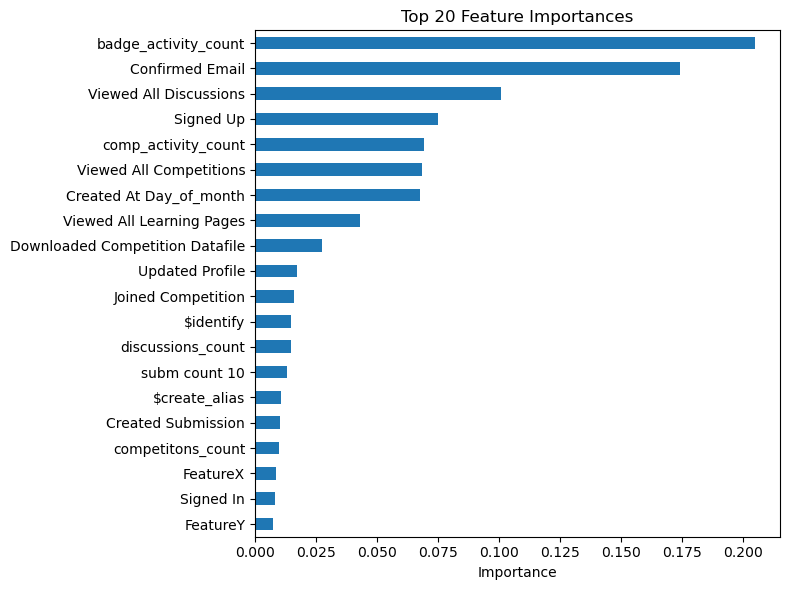

badge_activity_count               0.204934
Confirmed Email                    0.174226
Viewed All Discussions             0.100754
Signed Up                          0.074865
comp_activity_count                0.069154
Viewed All Competitions            0.068294
Created At Day_of_month            0.067811
Viewed All Learning Pages          0.042911
Downloaded Competition Datafile    0.027621
Updated Profile                    0.017361
Joined Competition                 0.015872
$identify                          0.014853
discussions_count                  0.014764
subm count 10                      0.013328
$create_alias                      0.010470
Created Submission                 0.010073
competitons_count                  0.009817
FeatureX                           0.008587
Signed In                          0.008177
FeatureY                           0.007204
dtype: float64


In [8]:
cols = plot_feature_importance(clf, X.columns, top_n=20)

In [9]:
X.columns

Index(['FeatureX', 'FeatureY', 'Created At Day_of_month', 'job_activity_count',
       'comp_activity_count', 'blog_activity_count', 'badge_activity_count',
       '$create_alias', '$identify', 'Accepted Team Leadership Transfer',
       'Applied To Job', 'Changed Password', 'Confirmed Email',
       'Created Submission', 'Created Team', 'Deleted Team',
       'Downloaded Competition Datafile', 'Invited Member To Team',
       'Joined Competition', 'Joined Team', 'Kicked Member From Team',
       'Left Team', 'Report Something', 'Signed In', 'Signed Out', 'Signed Up',
       'Transferred Team Leadership', 'Updated Comment', 'Updated Discussion',
       'Updated Discussion Team Participants', 'Updated Profile',
       'Updated Submission', 'Updated Team', 'Viewed All Competitions',
       'Viewed All Discussions', 'Viewed All Jobs',
       'Viewed All Learning Pages', 'Viewed Discussion', 'Viewed FAQ',
       'Votes (Up/Down)', 'competitons_count', 'subm count 10', 'subm count 3',
     

In [10]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
xgb = XGBClassifier(
    n_estimators=250,        # trees, tune with early stopping
    learning_rate=0.05,      # conservative, allows more trees
    max_depth=6,             # controls complexity
    min_child_weight=1,      # larger -> more conservative splits
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    reg_lambda=1,            # L2 regularization
    reg_alpha=0,             # L1 regularization
    scale_pos_weight=scale_pos_weight,      # adjust if imbalance exists (see below)
    objective="binary:logistic",
    eval_metric="logloss",   # use logloss during training
    random_state=42,
    n_jobs=-1,
    
)


In [11]:

xgb = train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, xgb)

Model training complete.
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1323
           1       0.68      0.76      0.72       491

    accuracy                           0.84      1814
   macro avg       0.79      0.81      0.80      1814
weighted avg       0.85      0.84      0.84      1814

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      5293
           1       0.79      0.87      0.83      1961

    accuracy                           0.90      7254
   macro avg       0.87      0.89      0.88      7254
weighted avg       0.91      0.90      0.90      7254



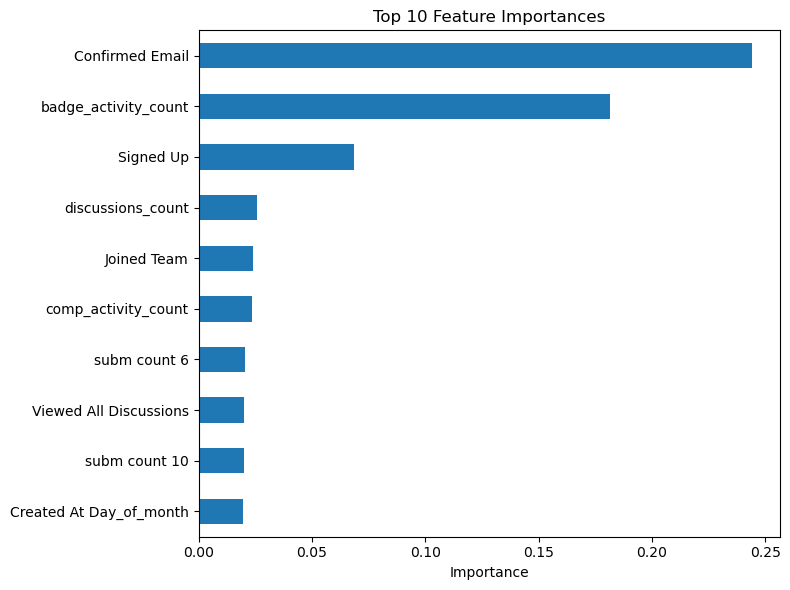

Confirmed Email            0.244133
badge_activity_count       0.181469
Signed Up                  0.068750
discussions_count          0.025659
Joined Team                0.024029
comp_activity_count        0.023670
subm count 6               0.020380
Viewed All Discussions     0.020103
subm count 10              0.019999
Created At Day_of_month    0.019803
dtype: float32


Index(['Confirmed Email', 'badge_activity_count', 'Signed Up',
       'discussions_count', 'Joined Team', 'comp_activity_count',
       'subm count 6', 'Viewed All Discussions', 'subm count 10',
       'Created At Day_of_month'],
      dtype='object')

In [12]:
plot_feature_importance(xgb, X.columns, top_n=10)

In [13]:
test_df = pd.read_csv("data/datatest.csv")

In [14]:
cols

Index(['badge_activity_count', 'Confirmed Email', 'Viewed All Discussions',
       'Signed Up', 'comp_activity_count', 'Viewed All Competitions',
       'Created At Day_of_month', 'Viewed All Learning Pages',
       'Downloaded Competition Datafile', 'Updated Profile',
       'Joined Competition', '$identify', 'discussions_count', 'subm count 10',
       '$create_alias', 'Created Submission', 'competitons_count', 'FeatureX',
       'Signed In', 'FeatureY'],
      dtype='object')

In [15]:
X

,FeatureX,FeatureY,Created At Day_of_month,job_activity_count,comp_activity_count,blog_activity_count,badge_activity_count,$create_alias,$identify,Accepted Team Leadership Transfer,...,subm count 10,subm count 3,subm count 8,subm count 9,subm count 6,subm count 7,subm count 5,subm count 4,comments_count,discussions_count
0,0,0,16,0,0,0,1,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,27,1,3,0,0,1.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,27,0,1,0,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,16,0,14,1,1,1.0,1.0,0.0,...,1,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9063,0,1,7,0,0,0,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9064,0,1,6,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9065,0,1,25,0,0,0,1,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9066,0,1,7,0,8,0,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X = test_df.select_dtypes(include=["number"]).drop(columns=["Created At Year","hour","minute","second","Countries_ID","Created At Month"])
# X = test_df[cols]
X_scaled = scaler.transform(X)

In [17]:
predictions = xgb.predict(X_scaled)
predictions2 = ran.predict(X_scaled)

In [18]:
sub = pd.DataFrame({
    'User_ID_Next_month_Activity': test_df.User_ID,
    'Active': predictions
})

sub2 = pd.DataFrame({
    'User_ID_Next_month_Activity': test_df.User_ID,
    'Active': predictions2
})

In [19]:
sub.User_ID_Next_month_Activity = sub.User_ID_Next_month_Activity + '_Month_5'
sub2.User_ID_Next_month_Activity = sub2.User_ID_Next_month_Activity + '_Month_5'

In [20]:
SampleSubmission = pd.read_csv("data/SampleSubmission.csv")

In [21]:
sub = pd.merge(SampleSubmission.drop(columns='Active'), sub, on='User_ID_Next_month_Activity', how='left').fillna(0)
sub2 = pd.merge(SampleSubmission.drop(columns='Active'), sub2, on='User_ID_Next_month_Activity', how='left').fillna(0)

In [22]:
sub.to_csv("xgb_submission.csv", index=False)
sub2.to_csv("rf_submission.csv", index=False)